In [0]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy.signal import convolve, convolve2d
import os
import shutil
import re
from tqdm import tqdm
from PIL import Image
from skimage.color import rgb2gray, gray2rgb
from sklearn.model_selection import train_test_split
import tensorflow as tf
# Keras Libraries
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import Flatten, Dense, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import h5py
from scipy.ndimage.filters import gaussian_filter
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle, class_weight

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def extract_images_b():
  with h5py.File('/content/drive/My Drive/project/dataset_new/task1_blurred.h5', 'r') as hf:
    x_train, x_test = hf['x_train'][:][..., None], hf['x_test'][:]
  with h5py.File('/content/drive/My Drive/project/dataset_new/task1_original.h5', 'r') as hf:
    y_train, y_test = hf['x_train'][:][..., None], hf['x_test'][:]
  return (x_train, y_train, x_test, y_test)

In [0]:
x_train, y_train, x_test, y_test = extract_images_b()

In [6]:
x_train.shape

(4949, 224, 224, 1)

In [7]:
# define U-Net
inputs = Input((224, 224, 1))

c1 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(inputs)
#c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(p1)
#c2 = Dropout(0.2)(c2)
c2 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(p2)
#c3 = Dropout(0.1)(c3)
c3 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(p3)
#c4 = Dropout(0.1)(c4)
c4 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(c4)
p4 = MaxPooling2D((2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(p4)
#c5 = Dropout(0.1)(c5)
c5 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(c5)

# up-convolution
u6 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(u6)
#c6 = Dropout(0.1)(c6)
c6 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(c6)

u7 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(u7)
#c7 = Dropout(0.1)(c7)
c7 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(c7)

u8 = Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = 'same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(u8)
#c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(c8)

u9 = Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(c8)
u9 = concatenate([u9, c1])
c9 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(u9)
#c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(c9)
output = Conv2D(1, (1, 1), activation = 'relu', padding = 'same')(c9)

u_net = Model([inputs], [output])
u_net.compile(optimizer = 'adam', loss = 'mse')
u_net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [8]:
u_net.fit(x_train, y_train,
          epochs = 30,
          batch_size = 32,
          validation_data = (x_test[:], y_test[:]))

Epoch 1/30
155/155 [==============================] - 21s 137ms/step - loss: 0.0320 - val_loss: 7.3572e-04
Epoch 2/30
155/155 [==============================] - 20s 126ms/step - loss: 6.6193e-04 - val_loss: 5.0934e-04
Epoch 3/30
155/155 [==============================] - 20s 126ms/step - loss: 4.7658e-04 - val_loss: 4.1719e-04
Epoch 4/30
155/155 [==============================] - 20s 126ms/step - loss: 4.1563e-04 - val_loss: 3.8572e-04
Epoch 5/30
155/155 [==============================] - 20s 126ms/step - loss: 3.4961e-04 - val_loss: 3.0766e-04
Epoch 6/30
155/155 [==============================] - 20s 126ms/step - loss: 2.9756e-04 - val_loss: 2.5923e-04
Epoch 7/30
155/155 [==============================] - 20s 126ms/step - loss: 2.6308e-04 - val_loss: 2.3091e-04
Epoch 8/30
155/155 [==============================] - 19s 125ms/step - loss: 2.3525e-04 - val_loss: 2.1516e-04
Epoch 9/30
155/155 [==============================] - 19s 124ms/step - loss: 2.2111e-04 - val_loss: 1.9973e-04
Epoch

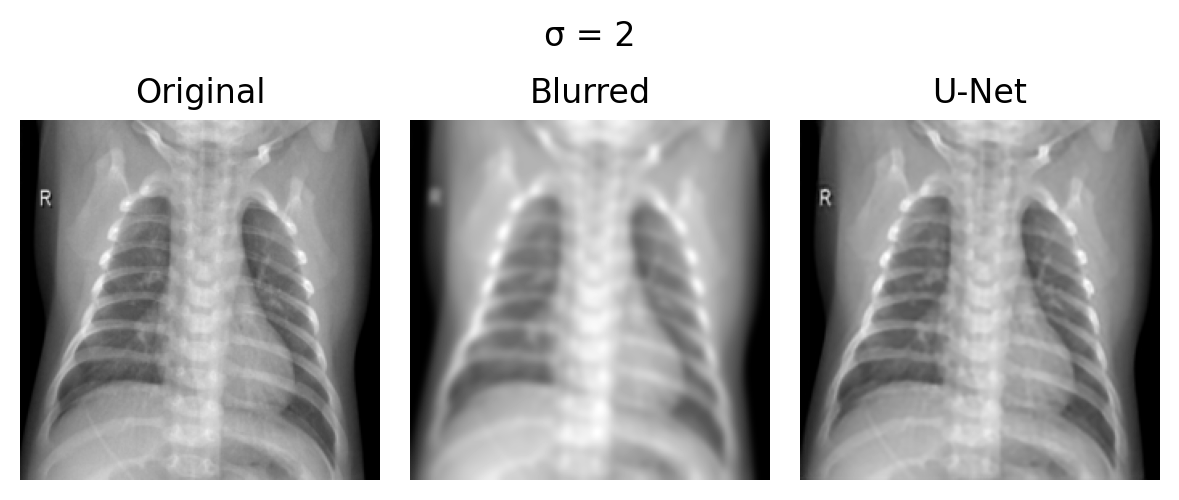

In [9]:
# display some example
plt.rcParams['figure.dpi'] = 200
image_unet = u_net.predict(x_test[70][None, ...])[0].reshape((224,224))
image_original = y_test[70]
image_blurred = x_test[70]
fig, ax = plt.subplots(1,3)
ax[0].imshow(image_original, cmap = 'gray')
ax[0].axis('off')
ax[0].set_title('Original')
ax[1].imshow(image_blurred, cmap = 'gray')
ax[1].axis('off')
ax[1].set_title('Blurred')
ax[2].imshow(image_unet, cmap = 'gray')
ax[2].axis('off')
ax[2].set_title('U-Net')
plt.suptitle('σ = 2', y = 0.85)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/u_net_2', dpi = 500)
plt.show()

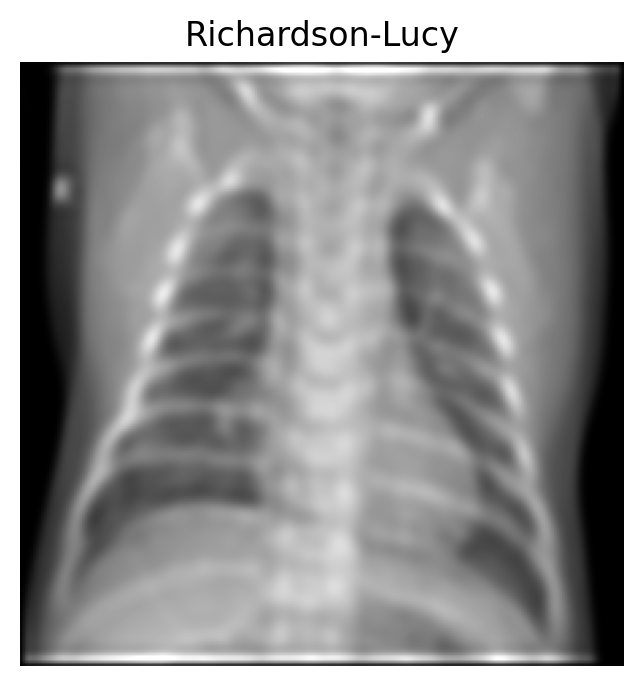

In [10]:
# compare to Richard-Lucy 
from skimage import restoration
# create a (2h+1) x (2h+1) delta image
max_h = 10
delta_image = np.zeros(shape = (2 * max_h + 1, 2 * max_h + 1))
delta_image[max_h][max_h] = 1
# get the (2h+1) x (2h+1) kernel 
K = gaussian_filter(delta_image, sigma = 2)
# shave 
index = K.nonzero()
start = (index[0][0],index[1][0])
end = (index[0][-1], index[1][-1])
K = K[start[0]:end[0]+1, start[1]:end[1]+1]
image_rl = restoration.richardson_lucy(x_test[70], K, iterations = 6)
plt.imshow(image_rl, cmap = 'gray')
plt.title('Richardson-Lucy')
plt.axis('off')
plt.savefig('/content/drive/My Drive/RL', dpi = 500)
plt.show()

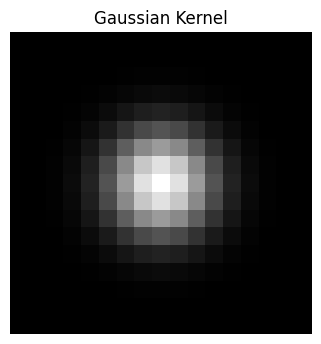

In [11]:
plt.rcParams['figure.dpi'] = 100
plt.imshow(K, cmap = 'gray')
plt.title('Gaussian Kernel')
plt.axis('off')
plt.show()

###•The codes below are used to test classification accuracy

In [0]:
def extract_images_c(task, dataset = 'original'):
  # task = 1 : normal vs pneumonia
  # task = 2 : bacterial vs viral 
    if task == 1:
        with h5py.File('/content/drive/My Drive/project/dataset_new/task1_' + dataset + '.h5', 'r') as hf:
            x_train, y_train, x_test, y_test = hf['x_train'][:], hf['y_train'][:, 0], hf['x_test'][:], hf['y_test'][:, 0]
            
    else:
        with h5py.File('/content/drive/My Drive/project/dataset_new/task2_' + dataset + '.h5', 'r') as hf:
            x_train, y_train, x_test, y_test = hf['x_train'][:], hf['y_train'][:, 0], hf['x_test'][:], hf['y_test'][:, 0]
    return (x_train, y_train, x_test, y_test) 

In [13]:
#VGG16

model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = model.output
x = Flatten()(x)
#x = Dense(4096, activation = 'relu')(x)
#x = Dense(1024, activation = 'relu')(x)
x = Dense(1, activation = 'sigmoid')(x)
vgg = Model(inputs = model.input, outputs = x)

for layer in vgg.layers[0:20]:
    layer.trainable = False
  
x_train, y_train, x_test, y_test = extract_images_c(1, 'original')
cw = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
cw = {0 : cw[0], 1 : cw[1] / 1.1}
x_train = np.repeat(x_train[..., np.newaxis], 3, -1)
x_test = np.repeat(x_test[..., np.newaxis], 3, -1)
x_train, y_train = shuffle(x_train, y_train)
#optimizer = Adam(lr = 1e-5)
optimizer = RMSprop(lr = 1e-5)
vgg.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=optimizer)
history = vgg.fit(x_train, y_train, 
                    class_weight = cw,
                    epochs = 10,
                    batch_size = 32,
                    validation_data = (x_test, y_test))

Epoch 1/10
155/155 [==============================] - 15s 99ms/step - loss: 0.5879 - accuracy: 0.6650 - val_loss: 0.5759 - val_accuracy: 0.8285
Epoch 2/10
155/155 [==============================] - 14s 92ms/step - loss: 0.4467 - accuracy: 0.8881 - val_loss: 0.4823 - val_accuracy: 0.8702
Epoch 3/10
155/155 [==============================] - 14s 92ms/step - loss: 0.3519 - accuracy: 0.9052 - val_loss: 0.4166 - val_accuracy: 0.8638
Epoch 4/10
155/155 [==============================] - 14s 92ms/step - loss: 0.2899 - accuracy: 0.9139 - val_loss: 0.3768 - val_accuracy: 0.8638
Epoch 5/10
155/155 [==============================] - 14s 92ms/step - loss: 0.2489 - accuracy: 0.9222 - val_loss: 0.3535 - val_accuracy: 0.8654
Epoch 6/10
155/155 [==============================] - 14s 92ms/step - loss: 0.2209 - accuracy: 0.9271 - val_loss: 0.3331 - val_accuracy: 0.8734
Epoch 7/10
155/155 [==============================] - 14s 91ms/step - loss: 0.1997 - accuracy: 0.9285 - val_loss: 0.3341 - val_accuracy:

In [14]:
# predict on blurring images
# extract blurring images
with h5py.File('/content/drive/My Drive/project/dataset_new/task1_blurred.h5', 'r') as hf:
            x_test_b, y_test_b = hf['x_test'][:][..., None], hf['y_test'][:, 0]
x_test_b_ = np.repeat(x_test_b[...], 3, -1)
result = vgg.evaluate(x_test_b_, y_test_b)


20/20 [==============================] - 1s 74ms/step - loss: 1.1838 - accuracy: 0.6250


In [15]:
# predict on deblurred images
x_test_b = u_net.predict(x_test_b)
x_test_b_ = np.repeat(x_test_b[...], 3, -1)
result = vgg.evaluate(x_test_b_, y_test_b)

20/20 [==============================] - 1s 74ms/step - loss: 0.3367 - accuracy: 0.8542
